In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [21]:
# Load dataset
df_train = pd.read_csv('/home/phuc/Desktop/ml1/mitbih_train.csv', header=None)

# Print the dataset
print(df_train.head())


        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0 

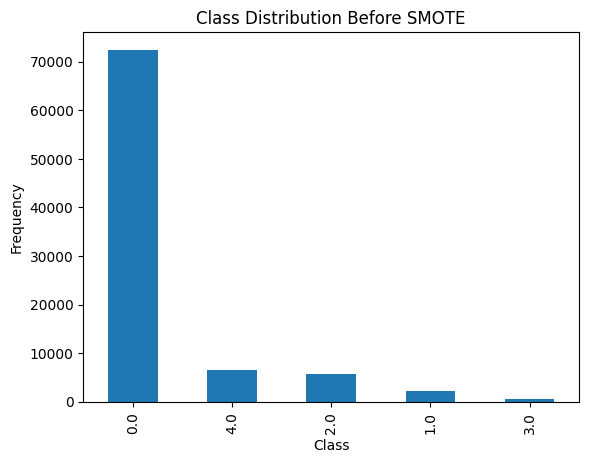

In [22]:
# Plot bar chart of class distribution
df_train.iloc[:, -1].value_counts().plot(kind='bar')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


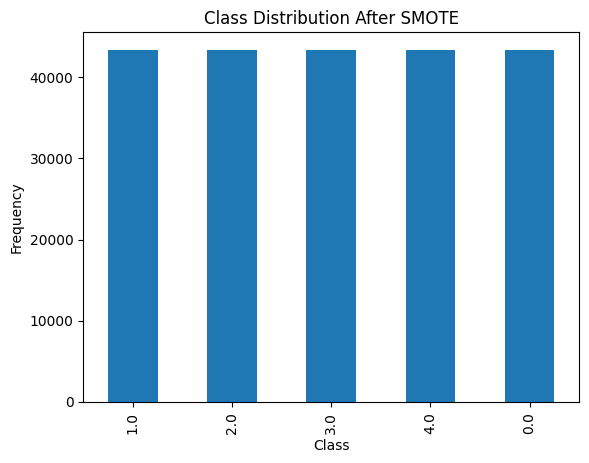

In [23]:
# Apply SMOTE
smote = SMOTE()

# Randomize max class count
max_class_count = df_train.iloc[:, -1].value_counts().max()
random_max_class_count = np.random.randint(max_class_count // 2, max_class_count + 1)
df_majority_class_reduced = df_train[df_train.iloc[:, -1] == df_train.iloc[:, -1].value_counts().idxmax()].sample(n=random_max_class_count, random_state=42)
df_minority_classes = df_train[df_train.iloc[:, -1] != df_train.iloc[:, -1].value_counts().idxmax()]

df_balanced = pd.concat([df_minority_classes, df_majority_class_reduced])

X_balanced = df_balanced.iloc[:, :-1]
y_balanced = df_balanced.iloc[:, -1]

X_sm, y_sm = smote.fit_resample(X_balanced, y_balanced)

# Plot bar chart of the dataset after oversampling
pd.Series(y_sm).value_counts().plot(kind='bar')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


In [24]:
# Basic exploration
print(df_train.describe())
print(df_train.iloc[:, -1].value_counts())


                0             1             2             3             4    \
count  87554.000000  87554.000000  87554.000000  87554.000000  87554.000000   
mean       0.890360      0.758160      0.423972      0.219104      0.201127   
std        0.240909      0.221813      0.227305      0.206878      0.177058   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.921922      0.682486      0.250969      0.048458      0.082329   
50%        0.991342      0.826013      0.429472      0.166000      0.147878   
75%        1.000000      0.910506      0.578767      0.341727      0.258993   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                5             6             7             8             9    \
count  87554.000000  87554.000000  87554.000000  87554.000000  87554.000000   
mean       0.210399      0.205808      0.201773      0.198691      0.196757   
std        0.171909      0.178481      0.177240    

In [25]:
class resblock(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv1 = nn.Conv1d(32, 32, 5, padding = 'same')
        self.Conv2 = nn.Conv1d(32, 32, 5, padding = 'same')
        self.Pool = nn.MaxPool1d(5, stride = 2)
        self.f = nn.ReLU()
    def forward(self, data):
        output = self.Conv2(self.f(self.Conv1(data)))
        output = output + data
        output = self.Pool(self.f(output))
        return output
    
class ECGmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv1 = nn.Conv1d(1, 32, 5, padding = 'same')
        self.Fc1 = nn.Linear(64, 32)
        self.Fc2 = nn.Linear(32, 5)
        self.res = []
        for i in range(5):
            self.res.append(resblock())
        self.f = nn.ReLU()
        self.Softmax = nn.Softmax()
        self.Flatten = nn.Flatten()
    def forward(self, data):
        output = self.Conv1(data)
        for resb in self.res:
            output = resb(output)
        output = self.Softmax(self.Fc2(self.f(self.Fc1(self.Flatten(output)))))
        return output

In [26]:
# Initialize the model
model = ECGmodel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [27]:
# Split your balanced data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.Tensor(X_train.values).unsqueeze(1)  # Adding channel dimension
y_train_tensor = torch.Tensor(y_train.values).long()

X_val_tensor = torch.Tensor(X_val.values).unsqueeze(1)  # Adding channel dimension
y_val_tensor = torch.Tensor(y_val.values).long()

# Create datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


/home/phuc/anaconda3/envs/mlmed2024/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch 1, Train Loss: 1.1742764296559907, Validation Loss: 1.0851569406554171
Epoch 2, Train Loss: 1.06748497886353, Validation Loss: 1.0566376977887229


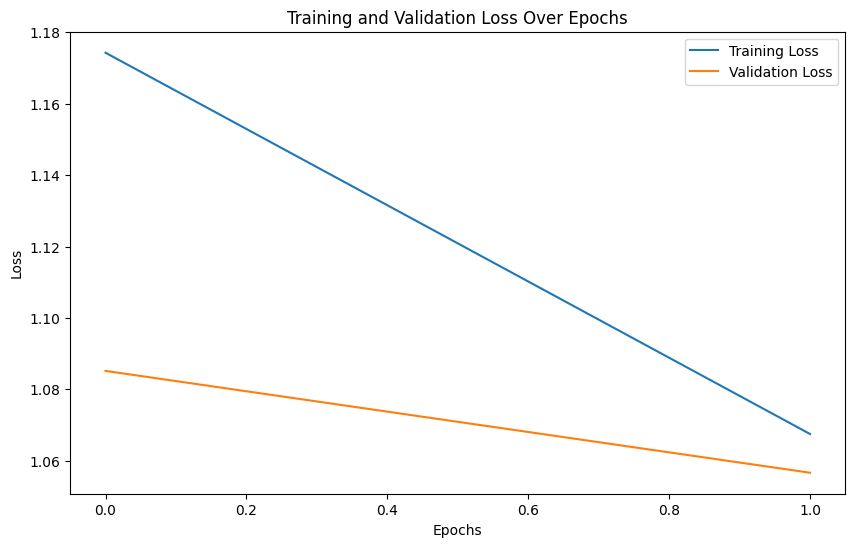

In [28]:
# Initialize lists to store loss values for plotting
train_losses = []
val_losses = []

# Training loop with validation
for epoch in range(10):  # Assuming 10 epochs for simplicity
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


/home/phuc/anaconda3/envs/mlmed2024/lib/python3.11/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


              precision    recall  f1-score   support

           0       0.98      0.82      0.89     18118
           1       0.17      0.65      0.27       556
           2       0.55      0.90      0.68      1448
           3       0.19      0.85      0.31       162
           4       0.93      0.88      0.91      1608

    accuracy                           0.83     21892
   macro avg       0.56      0.82      0.61     21892
weighted avg       0.92      0.83      0.86     21892



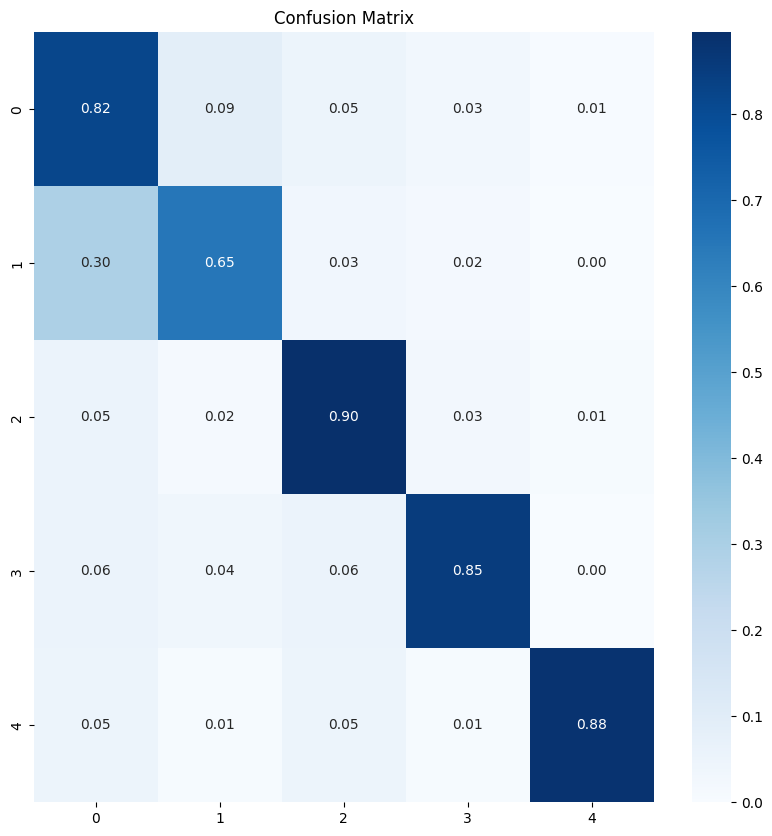

In [29]:
# Load test dataset
df_test = pd.read_csv('/home/phuc/Desktop/ml1/mitbih_test.csv', header=None)
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# Convert to tensors
X_test_tensor = torch.Tensor(X_test.values).unsqueeze(1)  # Adding channel dimension
y_test_tensor = torch.Tensor(y_test.values).long()

# Create dataset and dataloader for test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Evaluate
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

# Print evaluation metrics
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues')
plt.title('Confusion Matrix')
plt.show()